# Treinamento de modelo de reconhecimento de Objetos em fotos

## 1 - Preparação

### 1.1 - Carregamento das bibliotecas e métodos que carregam os dados
Nesta etapa vamos importar as bibliotecas que vamos usar neste experimento, e criar alguns mmétodos que serão usados para carregar nas nossas imagens de treino e os labels criados a partir do site make AI sense

In [1]:
from pathlib import Path
from typing import List, Tuple, Dict, Any
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

# Seleção de device: CUDA (NVIDIA) > MPS (Apple Silicon) > CPU
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else torch.device("cpu")
)
device

torch: 2.8.0+cpu
torchvision: 0.23.0+cpu


device(type='cpu')

### 1.2 - Criação dos métodos que processam os labels
Neste etapa vamos regristra os métodos que processam os labels das imagens de treino no padrão / formato YOLO que criamos com o site Make AI Sense e salvamos na pasta iamgens/labels.
Os arquivos de labels estão salvos com o mesmo nome do arquivo da imagem só que com a extensão .txt

In [2]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def read_classes_file(classes_file: Path):
    if not classes_file.exists():
        return []
    with open(classes_file, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

def read_yolo_label_file(label_path: Path) -> List[Tuple[int, list]]:
    """
    Lê .txt YOLO: class x_center y_center w h (normalizados em 0..1).
    Retorna lista de (class_id, [x_c, y_c, w, h]).
    """
    items = []
    if not label_path.exists():
        return items
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(float(parts[0]))
            x_c, y_c, bw, bh = map(float, parts[1:5])
            items.append((cls, [x_c, y_c, bw, bh]))
    return items

def infer_num_classes(labels_dir: Path) -> int:
    max_cls = -1
    for p in labels_dir.glob("*.txt"):
        for cls, _ in read_yolo_label_file(p):
            max_cls = max(max_cls, cls)
    return max_cls + 1 if max_cls >= 0 else 1

def yolo_to_xyxy(box_yolo, w, h):
    """ [x_c,y_c,w,h] (0..1) -> [x1,y1,x2,y2] em pixels """
    x_c, y_c, bw, bh = box_yolo
    x_c *= w; y_c *= h; bw *= w; bh *= h
    x1 = max(0.0, x_c - bw/2.0)
    y1 = max(0.0, y_c - bh/2.0)
    x2 = min(float(w), x_c + bw/2.0)
    y2 = min(float(h), y_c + bh/2.0)
    return [x1, y1, x2, y2]

### 1.3 - Método que varre os diretóios e processa as imagens
Nesta etapa vamos criar o método que vamos usar a frente para varrer os diretórios e importar as iamgens e labels

In [4]:
class YoloDetectionDataset(Dataset):
    def __init__(self, images_dir: str, labels_dir: str, img_size=None):
        """
        images_dir: pasta com imagens (apenas desta divisão)
        labels_dir: pasta com .txt YOLO (compartilhada entre splits)
        img_size: (W,H) para resize simples (opcional). Se None, mantém original.
        """
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        if not self.images_dir.exists():
            raise FileNotFoundError(f"Pasta de imagens não encontrada: {self.images_dir}")
        self.images = sorted([p for p in self.images_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        img_path = self.images[idx]
        lbl_path = self.labels_dir / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size

        # Resize simples (opcional)
        if self.img_size is not None:
            new_w, new_h = self.img_size
            sx, sy = new_w / orig_w, new_h / orig_h
            img = img.resize((new_w, new_h), Image.BILINEAR)
        else:
            new_w, new_h = orig_w, orig_h
            sx = sy = 1.0

        # Lê YOLO e converte p/ xyxy em pixels (ajustado ao resize)
        items = read_yolo_label_file(lbl_path)
        boxes = []
        labels = []
        for cls, box_norm in items:
            x1, y1, x2, y2 = yolo_to_xyxy(box_norm, orig_w, orig_h)
            x1 *= sx; x2 *= sx; y1 *= sy; y2 *= sy
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls)+1)

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target: Dict[str, Any] = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]).clamp(min=0) * (boxes[:, 3] - boxes[:, 1]).clamp(min=0),
            "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64),
        }

        img_t = TF.to_tensor(img)  # [C,H,W] 0..1
        return img_t, target

def collate_fn(batch):
    return tuple(zip(*batch))

## 2.0 - Importação das imagens e criação do DataSet

### 2.1 - Criar o DataSet
Aqui vamos varrer as pastas com as imagens de treino e os labels para a criação do DataSet

In [5]:
# Ajuste estes caminhos:
ROOT = Path("imagens")
LABELS_DIR = ROOT / "labels"
TRAIN_IMAGES_DIR = ROOT / "treino"
VAL_IMAGES_DIR   = ROOT / "validacao"
TEST_IMAGES_DIR  = ROOT / "teste"

IMG_SIZE = (640, 640)  # opcional; comente para usar tamanho original

# Classes
classes_txt = ROOT / "classes.txt"
class_names = read_classes_file(classes_txt)
if class_names:
    num_classes = len(class_names)
else:
    num_classes = infer_num_classes(LABELS_DIR)
print("Classes:", class_names if class_names else f"{num_classes} (inferidas)")

# Datasets
train_ds = YoloDetectionDataset(str(TRAIN_IMAGES_DIR), str(LABELS_DIR), img_size=IMG_SIZE)
val_ds   = YoloDetectionDataset(str(VAL_IMAGES_DIR),   str(LABELS_DIR), img_size=IMG_SIZE)
test_ds  = YoloDetectionDataset(str(TEST_IMAGES_DIR),  str(LABELS_DIR), img_size=IMG_SIZE)

# DataLoaders
BATCH_SIZE = 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, num_workers=0, collate_fn=collate_fn)  # batch=1 p/ inferência/plot
len(train_ds), len(val_ds), len(test_ds)

Classes: ['lagarta', 'percevejo-marrom']


(60, 10, 11)

## 3 - Treinar o modelo

### 3.1 - configurar os parametros do modelo
Vamos aqui otimizar como o modelo será treinado ajustando os parâmetros
 

In [6]:
# Modelo base
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Ajusta a cabeça de classificação (num_classes + 1 pelo background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes + 1
)
model = model.to(device)

# Otimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=5e-4, weight_decay=1e-4)

### 3.2 - Treinar o modelos
Aqui vamos de fato treinar o modelo


In [9]:
def train_one_epoch(model, optimizer, loader, device, epoch, print_freq=25):
    model.train()
    running = {}
    for i, (images, targets) in enumerate(loader, 1):
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        for k, v in loss_dict.items():
            running[k] = running.get(k, 0.0) + float(v.item())

        if (i % print_freq == 0) or (i == len(loader)):
            msg = " ".join([f"{k}={running[k]/i:.4f}" for k in sorted(running)])
            print(f"[epoch {epoch} | {i}/{len(loader)}] loss={sum(running.values())/i:.4f} {msg}")

@torch.no_grad()
def eval_epoch(model, loader, device):
    # model.train()
    tot = 0.0; n = 0
    for images, targets in loader:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        tot += float(sum(loss for loss in loss_dict.values()).item())
        n += 1
    return tot / max(1, n)

EPOCHS = 40
best_val = float("inf")
CKPT = "fasterrcnn_yolo_splits.pth"

for epoch in range(1, EPOCHS+1):
    # print(f"teste {epoch} " )
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_loss = eval_epoch(model, val_loader, device)
    print(f"[epoch {epoch}] val_loss={val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            "model_state": model.state_dict(),
            "num_classes": num_classes,
            "epoch": epoch,
            "img_size": IMG_SIZE,
            "class_names": class_names
        }, CKPT)
        print(f"✔️ checkpoint salvo: {CKPT} (val_loss={val_loss:.4f})")

[epoch 1 | 15/15] loss=0.1622 loss_box_reg=0.0806 loss_classifier=0.0655 loss_objectness=0.0105 loss_rpn_box_reg=0.0056
[epoch 1] val_loss=0.1506
✔️ checkpoint salvo: fasterrcnn_yolo_splits.pth (val_loss=0.1506)
[epoch 2 | 15/15] loss=0.1487 loss_box_reg=0.0769 loss_classifier=0.0556 loss_objectness=0.0109 loss_rpn_box_reg=0.0053
[epoch 2] val_loss=0.1354
✔️ checkpoint salvo: fasterrcnn_yolo_splits.pth (val_loss=0.1354)
[epoch 3 | 15/15] loss=0.1463 loss_box_reg=0.0742 loss_classifier=0.0584 loss_objectness=0.0085 loss_rpn_box_reg=0.0052
[epoch 3] val_loss=0.1157
✔️ checkpoint salvo: fasterrcnn_yolo_splits.pth (val_loss=0.1157)
[epoch 4 | 15/15] loss=0.1339 loss_box_reg=0.0717 loss_classifier=0.0490 loss_objectness=0.0077 loss_rpn_box_reg=0.0054
[epoch 4] val_loss=0.1243
[epoch 5 | 15/15] loss=0.1368 loss_box_reg=0.0708 loss_classifier=0.0529 loss_objectness=0.0075 loss_rpn_box_reg=0.0056
[epoch 5] val_loss=0.1091
✔️ checkpoint salvo: fasterrcnn_yolo_splits.pth (val_loss=0.1091)
[epoch

### 3.3 Testar o modelo


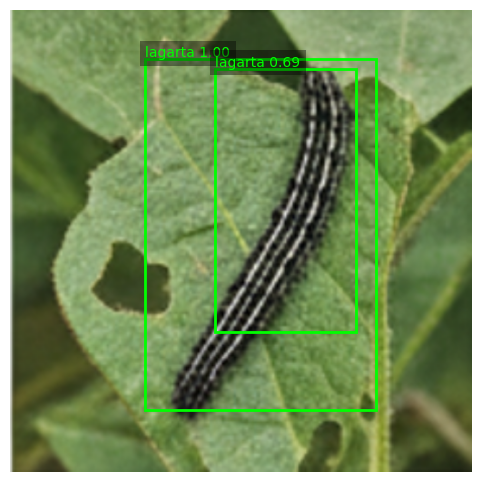

<Figure size 640x480 with 0 Axes>

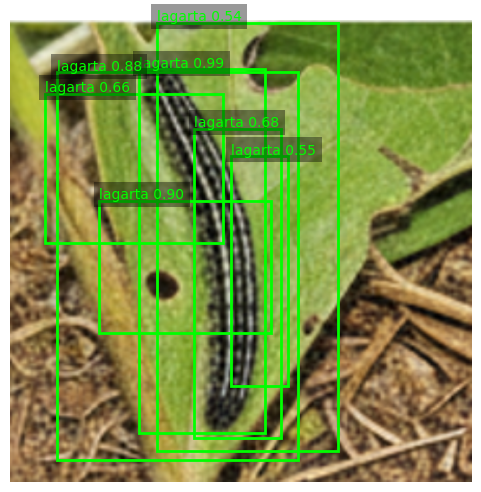

<Figure size 640x480 with 0 Axes>

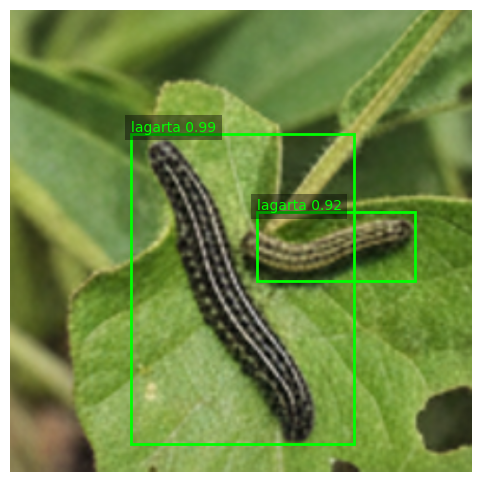

<Figure size 640x480 with 0 Axes>

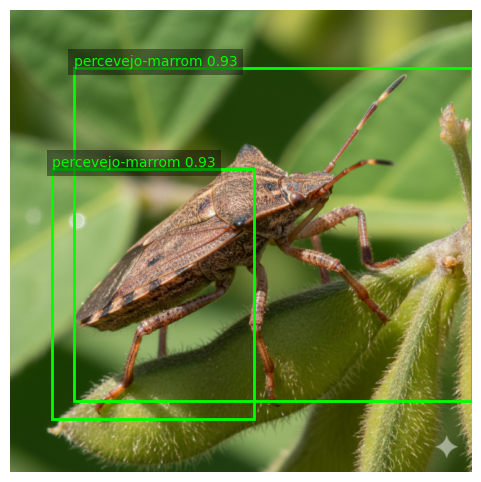

<Figure size 640x480 with 0 Axes>

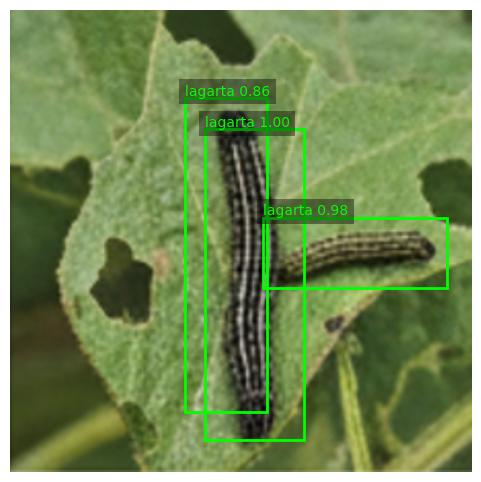

<Figure size 640x480 with 0 Axes>

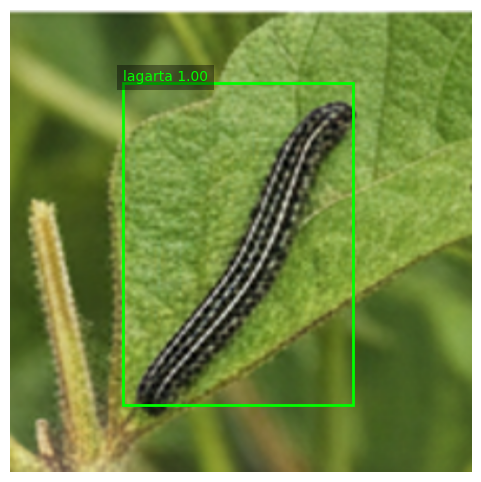

<Figure size 640x480 with 0 Axes>

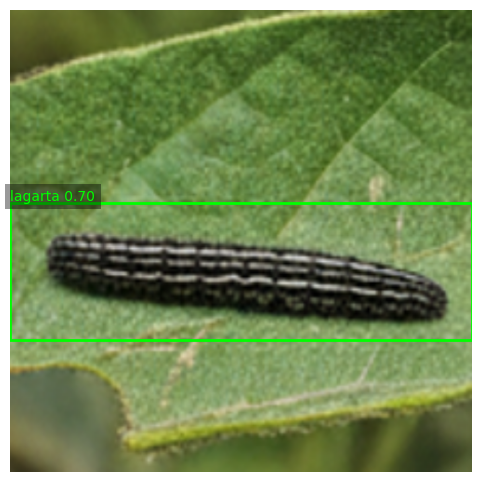

<Figure size 640x480 with 0 Axes>

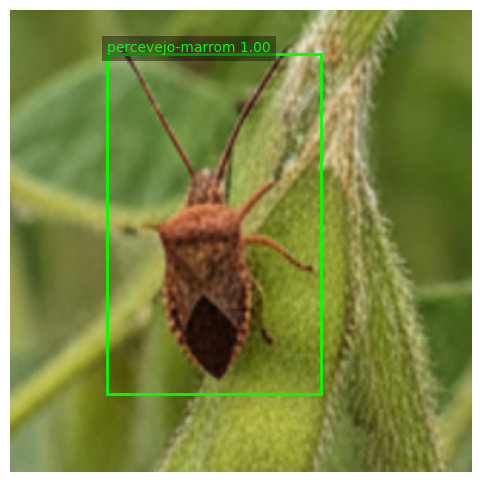

<Figure size 640x480 with 0 Axes>

In [ ]:
@torch.no_grad()
def predict_on_dataset(model, dataset, idxs, score_thr=0.5):
    model.eval()
    figs = []
    for idx in idxs:
        img_t, _ = dataset[idx]
        out = model([img_t.to(device)])[0]
        boxes  = out["boxes"].cpu()
        scores = out["scores"].cpu()
        labels = out["labels"].cpu()

        keep = scores >= score_thr
        boxes  = boxes[keep]; scores = scores[keep]; labels = labels[keep]

        img_np = (img_t.permute(1,2,0).cpu().numpy()).clip(0,1)
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(img_np)
        for b, s, l in zip(boxes, scores, labels):
            x1, y1, x2, y2 = b.numpy().astype(int)
            rect = plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                 fill=False, edgecolor="lime", linewidth=2)
            ax.add_patch(rect)
            # torchvision usa 0=background; suas classes YOLO começam em 0 => rótulo previsto vem como +1
            cid = int(l.item()) - 1
            name = str(cid)
            if class_names and 0 <= cid < len(class_names):
                name = class_names[cid]
            ax.text(x1, max(0, y1-3), f"{name} {s:.2f}", color="lime",
                    bbox=dict(facecolor="black", alpha=0.4, edgecolor="none"), fontsize=10)
        ax.axis("off")
        plt.show()
        # plt.savefig(f"result_{idx}.png", bbox_inches='tight')
        figs.append(fig)
    return figs

# exemplos da validação
if len(val_ds):
    sample_idxs = random.sample(range(len(val_ds)), k=min(4, len(val_ds)))
    _ = predict_on_dataset(model, val_ds, sample_idxs, score_thr=0.5)

# exemplos do teste
if len(test_ds):
    sample_idxs = random.sample(range(len(test_ds)), k=min(4, len(test_ds)))
    _ = predict_on_dataset(model, test_ds, sample_idxs, score_thr=0.5)

## 4 - Conclusão

O modelo foi preciso ao identificar os objetos nas imagens, porém conforme avançamos com mais iterações (épocas) no modelo, mais preciso ele fica.

Com 10 épocas tivemos uma taca de confiança de acerto da ordem entre 49 e 55%, com 30 épocas isso subiu para entre 79 e 100%.

### 4.1 - Preparando aplicação para testar o mdodelo

Execute o último bloco de código para salvar uma cópia do modelo na pasta da aplicação que vamos usar para testar o modelo com outras imagens


In [16]:
torch.save(model, "app/modelo1.pth")

### 4.2 - Executando a aplicação

Para executar a aplicação abra uma sessão no terminal, navegue até a pasta "app" e execute o comando abaixo:

```
python app.py
```

### 4.3 - Acesse a aplicação 

Usando o seu navegador favorito navegue na URL: Http://localhost:5000

### 4.4 - Usando Docker

Uma alternativa para usar a aplicação sem precisar retreinar o modelo é usando a imagem docker que já esta preparada com o modelo treinado e a aplicação.

Para isso, com ambiente docker instalado no seu computador execute o comando abaixo:

```
docker run -ti seberino/faster-cnn:1.0
```

Feito isso, faça o acesso a aplicação como explicado no item 4.3 deste documento